# Prenotazioni Hotel

## Sommario

### 1. Analisi Esplorativa dei Dati (AED)

Il Dataset Contiene i dati di due Hotel, uno di Città ed un Resort, ed è stato pubblicato ai fini di ricerca su Science Direct: https://www.sciencedirect.com/science/article/pii/S2352340918315191

I dettagli pubblicati su ScienceDirect ci forniscono alcune informazioni sugli Hotel, sappiamo ch entrambi sono situati in Portogallo a circa 300 Km l'uno dall'altro:
- Il Resort in Algarve
- Il Cittadino a Lisbona 

I dati contengono le informazioni relative a prenotazioni e arrivi dal 1° Luglio 2015 al 31 Agosto 2017

Cosa ci permettono di analizzare e capire questi dati?
- Da dove arrivano gli ospiti?
- Quanto pagano gli ospiti a notte?
- Come si evolve il prezzo durante l'anno?
- Quali sono i mesi più "trafficati"?
- Quanto tempo restano gli ospiti?
- Bookings by market segment
- Quante prenotazioni sono state cancellate?
- In quali mesi ci sono piu cancellazioni?

Queste sono le principali, ma in realta si puo rispondere a molte domande :-)

### 2. Predirre le Cancellazioni

Dal punto di vista di un Hotel o di un tour operator  poter prevedere le cancellazioni in maniera efficace può essere fondamentale per pianificare i turni del personale, le scorte alimentari e magari gestire con precisione l'Overbooking, Vendendo piu camere di quelle esistenti ma potendo contare su una precisa previsione delle disponibilità.

### 3. Valutazione sull'importanza delle caratteristiche
Quali sono le caratteristiche(Features) piu importanti per predirre efficacemente le cancellazioni?  

In [122]:
# Setup

# Un pò di import generici:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# Importiamo scikit-learn:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import eli5 # Feature importance evaluation

# Warnings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)



# Configuro un pò l'aspetto grafico, cosi quando stamperemo i dati o disegneremo dei grafici saranno almeno presentabili :-)
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "../Data/HotelBooking.csv"
set_intero = pd.read_csv(file_path)

In [123]:
# Diamo una sbirciata alle prime righe del DataSet per essere sicuri che sia stato importato
set_intero.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [124]:
# Controlliamo se ci manca qualche dato
set_intero.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [125]:
# Diamo un'occhiata alla defizione dei dati
set_intero.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [126]:
# Vediamo anche quali valori unici possono esserci
# pd.unique(set_intero)

In [127]:
# Puliamo i dati mancanti:
# agent: se l'agenzia non è specificata presumibilmente significa che la prenotazione è stata fatta direttamente dall'ospite
# company: se la compagnia non è specificata siamo probabilmente in presenza di un Privato
# country: il paese di appartenenza
dati_mancanti_sostituzione = {"children:": 0,"country": "Unknown", "agent": 0, "company": 0}

# grazie al metodo info() sappiamo che:
#     - children, agent e company sono campi numerici, quindi 0 risulta essere un ottimo valore di default nel caso il dato risulti mancante
#     - country invece è una stringa, non conosciamo lo stato di appartenenza quindi "Unknown" è un buon valore di default
set_intero_pulito = set_intero.fillna(dati_mancanti_sostituzione)

# "meal" contiene il valore "Undefined" che sappiamo essere equiparabile al Self-Catering la cui sigla è SC.
set_intero_pulito["meal"].replace("Undefined", "SC", inplace=True)

# Alcune righe non hanno nessuna informazione sul numero di Ospiti, questo puo essere causato da un errore nel sistema o da un inserimento manuale
# Possiamo eliminare queste righe.
zero_ospiti = list(set_intero_pulito.loc[set_intero_pulito["adults"]
                   + set_intero_pulito["children"]
                   + set_intero_pulito["babies"]==0].index)
set_intero_pulito.drop(set_intero_pulito.index[zero_ospiti], inplace=True)

In [128]:
# Verifichiamo che ora sia tutto pulito
set_intero_pulito.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [129]:
# Adesso possiamo verificare le Dimensioni reali del nostro Dataset
set_intero_pulito.shape

(119210, 32)

## 1. Analisi Esplorativa dei Dati (AED)

In [130]:
# Ai fini di analisi dividiamo il dataset in base all'Hotel
# Scartiamo anche le prenotazioni cancellate
set_resort = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "Resort Hotel") & (set_intero_pulito["is_canceled"] == 0)]
set_citta = set_intero_pulito.loc[(set_intero_pulito["hotel"] == "City Hotel") & (set_intero_pulito["is_canceled"] == 0)]

### Da dove arrivano gli ospiti?

In [131]:
# Prendiamo il numero di prenotazioni diviso per provenienza
prenotazioni_X_paese = pd.DataFrame(set_intero_pulito.loc[set_intero_pulito["is_canceled"] == 0]["country"].value_counts())

prenotazioni_X_paese.rename(columns={"country": "Numero di Ospiti"}, inplace=True)
ospiti_totali = prenotazioni_X_paese["Numero di Ospiti"].sum()
prenotazioni_X_paese["% Ospiti"] = round(prenotazioni_X_paese["Numero di Ospiti"] / ospiti_totali * 100, 2)
prenotazioni_X_paese["country"] = prenotazioni_X_paese.index


# Grafico a Torta
torta = px.pie(prenotazioni_X_paese,
             values="Numero di Ospiti",
             names="country",
             title="Paese di appartenenza",
             template="seaborn")
torta.update_traces(textposition="inside", textinfo="value+percent+label")
torta.show()

In [132]:
# e perche non su una mappa?
mappa_ospiti = px.choropleth(prenotazioni_X_paese,
                    locations=prenotazioni_X_paese.index,
                    color=prenotazioni_X_paese["% Ospiti"], 
                    hover_name=prenotazioni_X_paese.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Paese di appartenenza")
mappa_ospiti.show()

### Quanto pagano gli ospiti a notte?
Ogni Hotel ha diversi tipi le camere e trattamenti, e vista la tipologia di struttura la stagione gioca un ruolo fondamentale nell'applicazione dei prezzi, quindi lavoreremo con 2 set distinti

Una nota sulla valuta, non è specificata da nessuna parte, quindi visto che siamo in Portogallo l'€uro è la scelta piu logica.

In [133]:
# Consideriamo adulti e bambini come ospiti paganti, gli Infant li escludiamo.
# E' logico pensare  che per alcune offerte anche l'infant sia considerato come pagante, ai fini statistici potremmo provare a considerarlo, ma questo è il tipo di generalizzazione che bisogna fare per mitigare il rischio di Overfitting in un modello di Machine Learning
set_resort["prezzo_X_persona"] = set_resort["adr"] / (set_resort["adults"] + set_resort["children"])
set_citta["prezzo_X_persona"] = set_citta["adr"] / (set_citta["adults"] + set_citta["children"])

In [134]:
print("""Di tutte le prenotazioni non cancellate, per ogni tipo di camera e trattamento il prezzo medio a persona è:
Resort: {:.2f} € a notte.
Citta: {:.2f} € a notte."""
      .format(set_resort["prezzo_X_persona"].mean(), set_citta["prezzo_X_persona"].mean()))

Di tutte le prenotazioni non cancellate, per ogni tipo di camera e trattamento il prezzo medio a persona è:
Resort: 47.49 € a notte.
Citta: 59.27 € a notte.


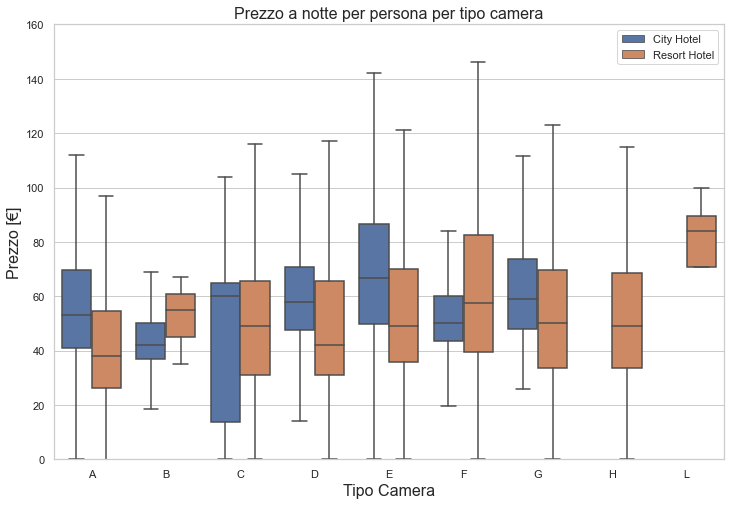

In [139]:
# normalize price per night (adr):
set_intero_pulito["prezzo_X_persona"] = set_intero_pulito["adr"] / (set_intero_pulito["adults"] + set_intero_pulito["children"])
set_intero_ospiti = set_intero_pulito.loc[set_intero_pulito["is_canceled"] == 0] # escludiamo le prenotazioni cancellate
prezzo_camere = set_intero_ospiti[["hotel", "reserved_room_type", "prezzo_X_persona"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="prezzo_X_persona",
            hue="hotel",
            data=prezzo_camere, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Prezzo a notte per persona per tipo camera", fontsize=16)
plt.xlabel("Tipo Camera", fontsize=16)
plt.ylabel("Prezzo [€]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

Questa figura mostra il prezzo medio per camera, in base al tipo e la deviazione standard

Nota: siccome nel Dataset i tipi camere sono stati anonimizzati non c'è la certezza che la camera di tipo A del resort e la camera dell'hotel in citta siano effettivamente lo stesso tipo.

### Come si evolve il prezzo durante l'anno?

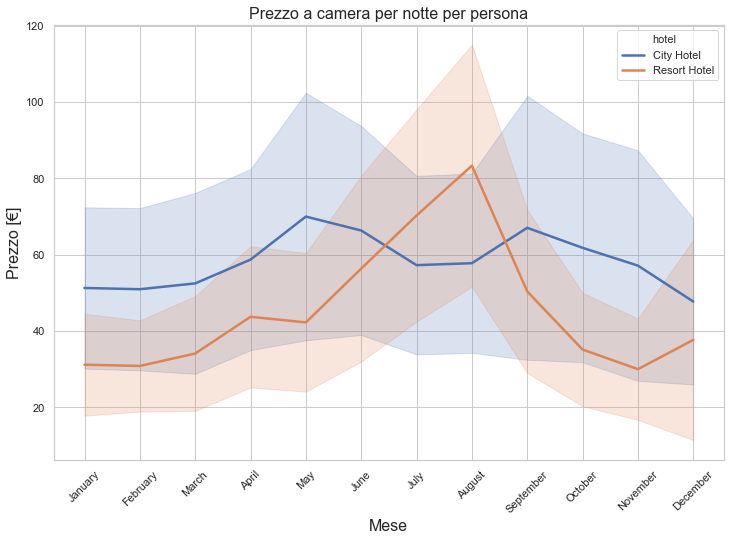

In [142]:
# grab data:
prezzo_camere_X_mese = set_intero_ospiti[["hotel", "arrival_date_month", "prezzo_X_persona"]].sort_values("arrival_date_month")

# order by month:
mesi_ordinati = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
prezzo_camere_X_mese["arrival_date_month"] = pd.Categorical(prezzo_camere_X_mese["arrival_date_month"], categories=mesi_ordinati, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="prezzo_X_persona", hue="hotel", data=prezzo_camere_X_mese, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Prezzo a camera per notte per persona", fontsize=16)
plt.xlabel("Mese", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Prezzo [€]", fontsize=16)
plt.show()

Come si poteva immaginare l'hotel in città ha un prezzo abbastanza stabile con i prezzi piu alti in primavera ed autunno.
Mentre il resort ha il picco in estate, risulta invece essere il piu economico durante il resto dell'anno

### Quali sono i mesi più "trafficati"?

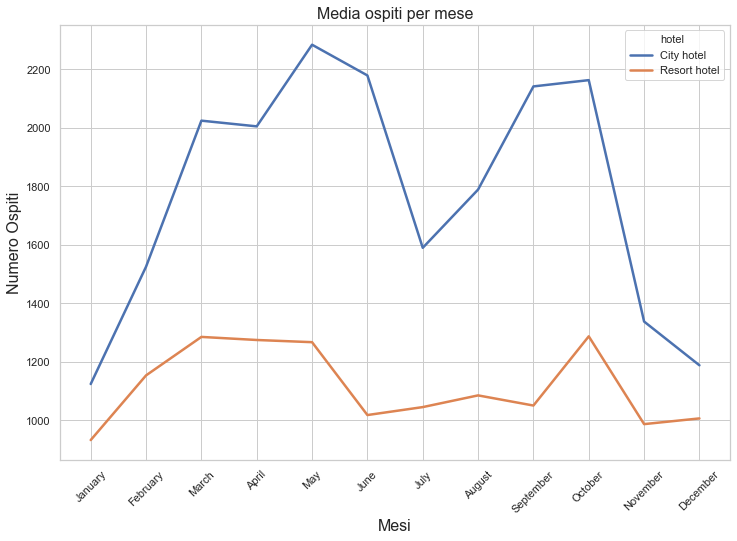

In [144]:
# Dividiamo i dataset:
resort_ospiti_X_mese = set_resort.groupby("arrival_date_month")["hotel"].count()
citta_ospiti_X_mese = set_citta.groupby("arrival_date_month")["hotel"].count()

resort_ospiti = pd.DataFrame({"month": list(resort_ospiti_X_mese.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_ospiti_X_mese.values)})

citta_ospiti = pd.DataFrame({"month": list(citta_ospiti_X_mese.index),
                    "hotel": "City hotel", 
                    "guests": list(citta_ospiti_X_mese.values)})
intero_ospiti = pd.concat([resort_ospiti,citta_ospiti], ignore_index=True)


intero_ospiti["month"] = pd.Categorical(intero_ospiti["month"], categories=mesi_ordinati, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
intero_ospiti.loc[(intero_ospiti["month"] == "July") | (intero_ospiti["month"] == "August"),
                    "guests"] /= 3
intero_ospiti.loc[~((intero_ospiti["month"] == "July") | (intero_ospiti["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=intero_ospiti, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Media ospiti per mese", fontsize=16)
plt.xlabel("Mesi", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Numero Ospiti", fontsize=16)
plt.show()

# Da Qui!

The City hotel has more guests during spring and autumn, when the prices are also highest.   
In July and August there are less visitors, although prices are lower.  

Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest.  
Both hotels have the fewest guests during the winter.

### Quanto tempo restano gli ospiti?

In [ ]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

In [ ]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [ ]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

For the city hotel there is a clear preference for 1-4 nights.  
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular. 

### Bookings by market segment

In [ ]:
# total bookings per market segment (incl. canceled)
segments=full_data_cln["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

In [ ]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=full_data_cln,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

On average, groups get the best prices and Airlines pay approximately twice as much.  
  
What are possible resons for the high prices paid by Airlines?

In [ ]:
# Summarize Relevant data:
Airline_data = full_data_cln.loc[full_data_cln["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

Non_Airline_data = full_data_cln.loc[full_data_cln["market_segment"]!= "Aviation"][["is_canceled",
                                                                                    "adults",
                                                                                    "lead_time",
                                                                                    "adr_pp",]].describe()

In [ ]:
Airline_data

In [ ]:
Non_Airline_data

- Lead time for bookings from Aviation is very short: Mean 4 days vs. 104 days for other bookings.
- Airlines NEED a place for their crews to stay.
- Airline personel usually gets one room per person - more total rooms required compared to families.

### Quante prenotazioni sono state cancellate?

In [ ]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

### In quali mesi ci sono piu cancellazioni?

In [ ]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

For the City hotel the relative number of cancelations is around 40 % throughout the year.  
For the Resort hotel it is highest in the summer and lowest during the winter. 